# Shifted Voronois

One interesting way to increase a bit the spatial awareness of the voronois is to consider the azimuth angle that antennas may be using to focus their coverage. This will give a better distinction of space as most Voronois represeting a base station will be broken into 3 sectors to optimize coverage in urban environments.

In [1]:
import random

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely import geometry,wkt
from geovoronoi import voronoi_regions_from_coords

# Functions

In [2]:
def generate_random_points(n, lat_min, lat_max, lon_min, lon_max):
    points = []
    for _ in range(n):
        lat = random.uniform(lat_min, lat_max)
        lon = random.uniform(lon_min, lon_max)
        points.append((lat, lon))
    return points

In [5]:
"""
Estimates the direction of coverage of an antenna in a base station
"""
def coverage_direction(lat,lon,real_azimut,radius):
    azimut = 90 - real_azimut 
    az_lon = lon + radius*np.cos(np.deg2rad(azimut))
    az_lat = lat + radius*np.sin(np.deg2rad(azimut))
    return az_lat,az_lon

# Calculating shifted voronois

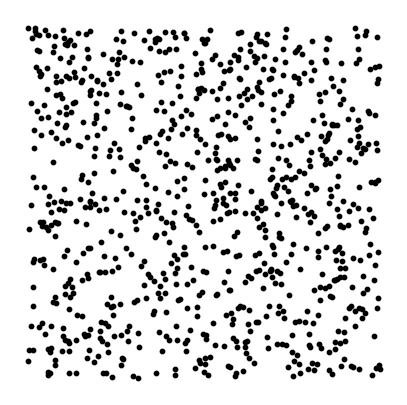

In [123]:
"""
Example scenario witih N points over space
"""
n_points = 900
lat_min, lat_max = 48.8, 48.91  
lon_min, lon_max = 2.2, 2.5

random_points = generate_random_points(n_points, lat_min, lat_max, lon_min, lon_max)
df_bs_locations = pd.DataFrame(random_points,columns=['lat','lon'])

# Adding a pseudo antenna identifier, as we want to keep the notion of base station
df_bs_locations['bs_id'] = df_bs_locations.index.astype(str)

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(df_bs_locations['lon'], df_bs_locations['lat'], s=10,color='black')
ax.axis('off')
plt.show()

In [125]:
"""
Let's say that 90% of our base stations in this example have directional antennas, 
all focusing in having 3 sectors. Let's add this notion to our current set. 

The example angles here would be 30, 150 and 270 (120 sep.)

The remaining 10% will be omni-directional antennas (azimuth angle = 0).
"""
df_bs_locations_shifted = df_bs_locations.copy()

df_bs_locations_shifted['azimuth'] = 0

directional_share = 0.9
n_directional = int(n_points*directional_share)

omni_antennas = df_bs_locations_shifted.loc[:n_points-n_directional-1]
directional_antennas = df_bs_locations_shifted.loc[n_points-n_directional:].reset_index(drop=True)

# Adding the azimuth angle to the directional antennas
directional_antennas = directional_antennas.loc[directional_antennas.index.repeat(3)].reset_index(drop=True)
directional_antennas['azimuth'] = [30,150,270]*n_directional

df_bs_locations_shifted = pd.concat([omni_antennas,directional_antennas]).reset_index(drop=True)

In [129]:
"""
Shifts the antennas slightly to the direction of their azimuth. 
Needed to calculate the new latlon id so we can later have new voronois the consider the propagation path
"""

for bs_id in df_bs_locations_shifted['bs_id'].unique():
    place_lat = df_bs_locations_shifted.loc[df_bs_locations_shifted.bs_id==bs_id,'lat'].unique()[0]
    place_lon = df_bs_locations_shifted.loc[df_bs_locations_shifted.bs_id==bs_id,'lon'].unique()[0]
    azimut_list = list(df_bs_locations_shifted.loc[df_bs_locations_shifted.bs_id==bs_id,'azimuth'].unique())
    
    if len(azimut_list)==1:
        pass
    else:
        temp_dfs = []
        #Coverage direction 
        for real_azimut in azimut_list:
            az_lat,az_lon = coverage_direction(place_lat,place_lon,real_azimut,0.0001)
            df_temp = df_bs_locations_shifted.loc[(df_bs_locations_shifted.bs_id==bs_id) & (df_bs_locations_shifted.azimuth==real_azimut)].copy()
            df_temp['lat'] = az_lat
            df_temp['lon'] = az_lon
            temp_dfs.append(df_temp)
                    
        df_new_antennas = pd.concat(temp_dfs, ignore_index=True)
        df_bs_locations_shifted = df_bs_locations_shifted.loc[df_bs_locations_shifted.bs_id!=bs_id]
        df_bs_locations_shifted = pd.concat([df_bs_locations_shifted,df_new_antennas],ignore_index=True)

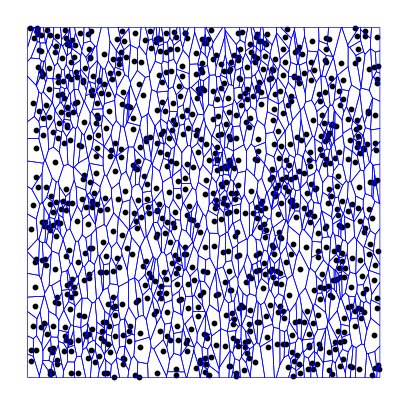

In [130]:
"""
Calculatin the voronois without the shift
"""
lat_point_list = [lat_min, lat_max, lat_max, lat_min]
lon_point_list = [lon_min, lon_min, lon_max, lon_max]
boundary_box = geometry.Polygon(zip(lon_point_list, lat_point_list))
coords = np.array((df_bs_locations['lon'],df_bs_locations['lat'])).T

voronois, pts = voronoi_regions_from_coords(coords,boundary_box)

# Organizing these geometries into the original dataframe
df_bs_locations['geometry'] = None
for i in range(0,len(pts)):
    for j in range(0,len(pts[i])):
        df_bs_locations.loc[pts[i][j],'geometry'] = voronois[i]
        
df_bs_locations = gpd.GeoDataFrame(df_bs_locations,crs="EPSG:4326") # These are generated as WGS84; it's good to convert to a better CRS in case there's a need to calculate area

# Plotting
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(df_bs_locations['lon'], df_bs_locations['lat'], s=10,color='black')
for row in df_bs_locations.iterrows():
    ax.plot(row[1]['geometry'].exterior.xy[0],row[1]['geometry'].exterior.xy[1],color='blue',lw=0.5)
ax.axis('off')
plt.show()


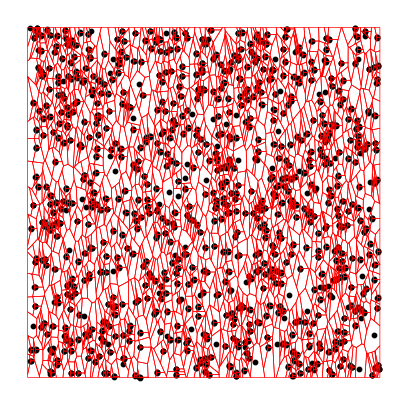

In [ ]:
"""
Calculatin the voronois with the shift
"""
lat_point_list = [lat_min, lat_max, lat_max, lat_min]
lon_point_list = [lon_min, lon_min, lon_max, lon_max]
boundary_box = geometry.Polygon(zip(lon_point_list, lat_point_list))
coords = np.array((df_bs_locations_shifted['lon'],df_bs_locations_shifted['lat'])).T

voronois, pts = voronoi_regions_from_coords(coords,boundary_box)

# Organizing these geometries into the original dataframe
df_bs_locations_shifted['geometry'] = None
for i in range(0,len(pts)):
    for j in range(0,len(pts[i])):
        df_bs_locations_shifted.loc[pts[i][j],'geometry'] = voronois[i]
        
df_bs_locations_shifted = gpd.GeoDataFrame(df_bs_locations_shifted,crs="EPSG:4326") # These are generated as WGS84; it's good to convert to a better CRS in case there's a need to calculate area

# Plotting
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(df_bs_locations_shifted['lon'], df_bs_locations_shifted['lat'], s=10,color='black')
for row in df_bs_locations_shifted.iterrows():
    ax.plot(row[1]['geometry'].exterior.xy[0],row[1]['geometry'].exterior.xy[1],color='red',lw=0.5)
ax.axis('off')
plt.show()


In [132]:
df_bs_locations.shape,df_bs_locations_shifted.shape

((900, 4), (2520, 5))